In [5]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import glob
import shutil
import numpy as np
import folium
import polars as pl

In [ ]:
import os
import time
from urllib.parse import quote
from bs4 import BeautifulSoup
import requests



url = "https://insideairbnb.com/get-the-data/"
script_dir = os.getcwd()
file_path = os.path.join(script_dir, '../raw/currency.csv')
currency_csv = pd.read_csv(file_path)
LARGE_CITY =['Beijing, Beijing, China', 'New Zealand', 'Broward County, Florida, United States']


def scrape_data():
	response = requests.get(url, timeout=20)
	all_content = response.content
	soup = BeautifulSoup(all_content, 'lxml')
	all_cities_data = dict()
	cities = soup.find_all("h3")
	for city in cities:
		all_cities_data[city.get_text(strip=True)] = []
		table = city.find_next_sibling(class_=["data", "table", "table-hover", "table-striped"]).find_all("a")
		for link in table:
			all_cities_data[city.get_text(strip=True)].append(quote(link["href"], safe=':/?=&'))
	return all_cities_data




def load_review(city = 'Singapore, Singapore, Singapore'):
	start_time = time.perf_counter()
	try:
		csv_reviews_path = scrape_data()[city][2]
	except Exception as e:
		if city == "Bangkok, Central Thailand, Thailand":
			csv_reviews_path = os.path.join(script_dir,"../../raw/bangkok/2025-06-24/data/reviews.csv.gz")
		elif city == "Taipei, Northern Taiwan, Taiwan":
			csv_reviews_path = os.path.join(script_dir,"raw/taipei/2025-06-29/data/reviews.csv.gz")
		else:
			csv_reviews_path = os.path.join(script_dir,"raw/singapore/2025-09-28/data/reviews.csv.gz")
	pf= pl.scan_csv(
		csv_reviews_path,
		low_memory = False,
	)
	pf = pf.with_columns(
		pl.col("comments").str.replace_all("<br/>", "\n"),
	)
	pf=pf.reverse()
	df = pf.collect().to_pandas()
	end_time = time.perf_counter()
	elapsed_time = end_time - start_time
	print(f"reviews executed in {elapsed_time:.4f} seconds.")
	return df
def load_listings(city = 'Singapore, Singapore, Singapore'):
	start_time = time.perf_counter()
	country = city.split(',')[0].strip().upper()
	try:
		exchange_rate = currency_csv.loc[currency_csv['Country'] == country, 'Exchange_Rate'].item()
	except Exception as e:
		exchange_rate = 1

	try:
		csv_listings_path = scrape_data()[city][0]
	except Exception as e:
		if city == "Bangkok, Central Thailand, Thailand":
			csv_listings_path = os.path.join(script_dir,"raw/bangkok/2025-06-24/data/listings.csv.gz")
		elif city == "Taipei, Northern Taiwan, Taiwan":
			csv_listings_path = os.path.join(script_dir,"raw/taipei/2025-06-29/data/listings.csv.gz")
		else:
			csv_listings_path = os.path.join(script_dir,"raw/singapore/2025-09-28/data/listings.csv.gz")
	pf = pl.scan_csv(csv_listings_path, schema_overrides={"id": pl.String, 'license': pl.String})
	pf = pf.with_columns(
		pl.col("price").str.replace_all(r"[\$,]", "").alias("price")
	).with_columns(
		pl.col("price").cast(pl.Float64).alias("price")
	).with_columns(
		(pl.col("price") / exchange_rate).alias("price")
	)
	df = pf.collect().to_pandas()

	end_time = time.perf_counter()
	elapsed_time = end_time - start_time
	print(f"listings executed in {elapsed_time:.4f} seconds.")
	return df


def load_geojson(city = 'Singapore, Singapore, Singapore'):
	start_time = time.perf_counter()
	try:
		geojson_path = scrape_data()[city][6]
	except Exception as e:
		if city == "Bangkok, Central Thailand, Thailand":
			geojson_path = os.path.join(script_dir,"raw/bangkok/2025-06-24/visualisations/neighbourhoods.geojson")
		elif city == "Taipei, Northern Taiwan, Taiwan":
			geojson_path = os.path.join(script_dir,"raw/taipei/2025-06-29/visualisations/neighbourhoods.geojson")
		else:
			geojson_path = os.path.join(script_dir,"raw/singapore/2025-09-28/visualisations/neighbourhoods.geojson")
	

	geojson_data = gpd.read_file(geojson_path, encoding='utf-8')
	world_bounds = gpd.read_file(os.path.join(script_dir, '../world.geojson'),encoding='utf-8')
	end_time = time.perf_counter()
	elapsed_time = end_time - start_time
	print(f"geojson executed in {elapsed_time:.4f} seconds.")
	return geojson_data, world_bounds 

all_cities_data = scrape_data()
list_pd = []
csv_file = 'output.csv'
all = []
for city in all_cities_data.keys():
    df_new = load_listings(city)
    df_new2 = load_review(city)
    df_new3,_ = load_geojson(city)
    if df_new is not None:
        file_exists = os.path.isfile(csv_file)
        log_data = {'City': [city], 'Memory_Usage_Bytes': [int(df_new.memory_usage(index=True, deep=True).sum()+df_new2.memory_usage(index=True, deep=True).sum()+ df_new3.memory_usage(index=True, deep=True).sum())]}
        del df_new
        del df_new2
        del df_new3
        all.append(log_data)
end_time = time.perf_counter()
print(sorted(all, key=lambda item: item['Memory_Usage_Bytes'],reverse=True))


listings executed in 0.2460 seconds.
reviews executed in 0.6327 seconds.


DataSourceError: /home/lamph/Inside-Airbnb-Singapore/src/world.geojson: No such file or directory

In [ ]:
csv_file = 'output.csv'
df = pd.read_csv(csv_file)
df["amenities"]

0          ["Carbon monoxide alarm", "Air conditioning", ...
1          ["HDTV with standard cable, Apple TV", "Heatin...
2          ["Wine glasses", "Air conditioning", "Heating"...
3          ["Air conditioning", "Heating", "Private entra...
4          ["Heating", "Private entrance", "Coffee maker"...
                                 ...                        
1610774    ["Wifi", "Smoke alarm", "Washer", "Building st...
1610775    ["Wifi", "Pets allowed", "Outdoor dining area"...
1610776    ["Wifi", "Smoke alarm", "First aid kit", "Exte...
1610777    ["Wifi", "Pets allowed", "BBQ grill", "Beach a...
1610778    ["Wifi", "Smoke alarm", "First aid kit", "Wash...
Name: amenities, Length: 1610779, dtype: object

In [ ]:
pd.set_option('display.max_columns', None)  
pf3 =  pd.read_csv("../raw/bangkok/2025-06-24/data/listings.csv.gz",low_memory=False)
listings = pd.read_csv("../raw/singapore/2025-09-28/data/listings.csv.gz",low_memory=False) 

In [ ]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3693 entries, 0 to 3692
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            3693 non-null   int64  
 1   listing_url                                   3693 non-null   object 
 2   scrape_id                                     3693 non-null   int64  
 3   last_scraped                                  3693 non-null   object 
 4   source                                        3693 non-null   object 
 5   name                                          3693 non-null   object 
 6   description                                   3622 non-null   object 
 7   neighborhood_overview                         1720 non-null   object 
 8   picture_url                                   3693 non-null   object 
 9   host_id                                       3693 non-null   i

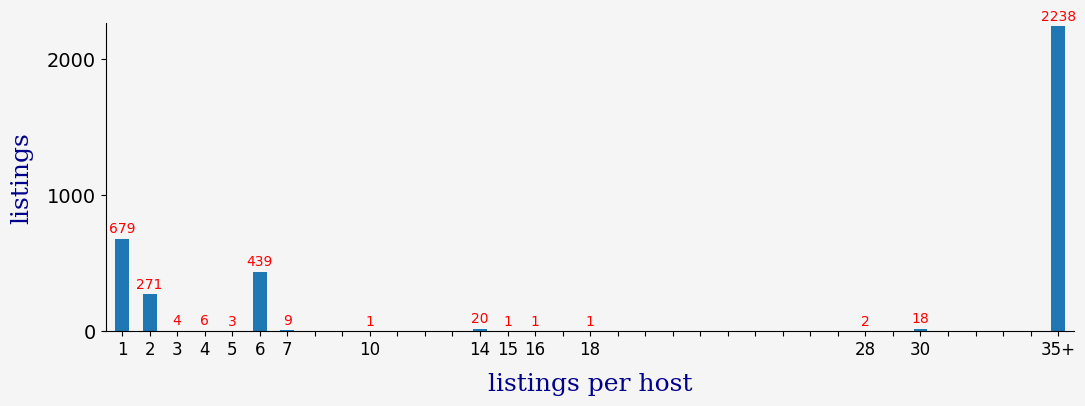

In [ ]:
from turtle import color
from matplotlib import pyplot as plt, ticker
import pandas as pd


# listings.info()
limit_data= listings
limit_data.loc[listings['minimum_nights']>35,'minimum_nights'] = 35
data= limit_data['minimum_nights'].value_counts()

data_index = [item for item in range(1,36) if item not in data.index]
new_row = pd.Series(0, index= data_index)
data = pd.concat([data, new_row])
data.sort_index(inplace=True)
data
fig4, ax4 = plt.subplots(figsize=(12.5,4))
bar3 = ax4.bar([str(i) for i in range(1, 35)]+["35+"],list(data), width= 0.5)
ax4.margins(0.01)  
ax4.yaxis.set_major_locator(ticker.MultipleLocator(base=1000))
ax4.set_xlabel("listings per host",fontdict={'family': 'serif', 'color': 'darkblue', 'size': 18}, labelpad=10)
ax4.set_ylabel("listings",fontdict={'family': 'serif', 'color': 'darkblue', 'size': 18}, labelpad=10)
ax4.tick_params(axis='x', labelsize=12) 
ax4.tick_params(axis='y', labelsize=14)
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
fig4.patch.set_facecolor('#f5f5f5')
ax4.set_facecolor("#f5f5f5")
xticks = ax4.get_xticklabels()
for i in range(len(xticks)-1):
    if data[int(xticks[i].get_text())] == 0:
        xticks[i].set_visible(False)
for bar in bar3:
    height = bar.get_height()
    if height != 0:
        ax4.text(
                    bar.get_x() + bar.get_width() / 2,
                    height + 20,
                    s = f'{height}',
                    horizontalalignment='center',     
                    verticalalignment='bottom',   
                    color = 'red',
                    fontsize=10,
                    fontweight= 400
                )




In [ ]:
from numpy import sort


pf3 = pf3[["host_name","room_type","calculated_host_listings_count"]]
df= pd.get_dummies(pf3,columns=["room_type"], prefix='', prefix_sep='')

a = df.groupby("host_name")
b = a.sum().sort_values(by='calculated_host_listings_count', ascending=False).head()
b['calculated_host_listings_count'] = a.count()['calculated_host_listings_count']
b

,host_total_listings_count,Entire home/apt,Hotel room,Private room,Shared room
host_name,,,,,
Sidharth,219,219,0,0,0
Tushita,120,119,0,1,0
Luis Higinio,29,0,0,29,0
Neha,135,134,0,1,0
Keng Song,91,2,0,89,0


In [ ]:

pf4 = pd.read_csv("../raw/bangkok/2024-12-25/data/reviews.csv.gz",low_memory=False)
# len(pf3[pf3["host_id"]==1439258])
pf3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3693 entries, 0 to 3692
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            3693 non-null   int64  
 1   listing_url                                   3693 non-null   object 
 2   scrape_id                                     3693 non-null   int64  
 3   last_scraped                                  3693 non-null   object 
 4   source                                        3693 non-null   object 
 5   name                                          3693 non-null   object 
 6   description                                   3622 non-null   object 
 7   neighborhood_overview                         1720 non-null   object 
 8   picture_url                                   3693 non-null   object 
 9   host_id                                       3693 non-null   i

<Axes: >

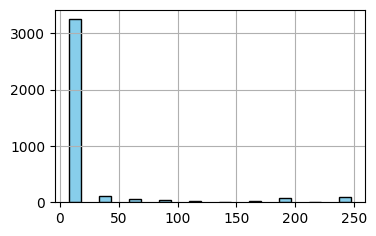

In [ ]:
fig, ax = plt.subplots(figsize=(4, 2.5))
fig, ax = plt.subplots(figsize=(4, 2.5))
bar = ax.bar()


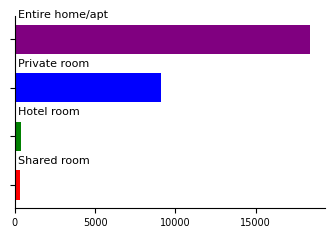

In [ ]:
counts = list(listings['room_type'].value_counts())[::-1]
room_type = listings['room_type'].unique()[::-1]
bar_colors = ['red', 'green', 'blue', 'purple']
fig, ax = plt.subplots(figsize=(4, 2.5))
bar_container = ax.barh(room_type,counts,height=0.6,color=bar_colors)
ax.tick_params(axis='y', labelleft=False)
for i, room in enumerate(room_type):
    ax.text(200, 
            i+0.5,            
            room,      
            ha='left',     
            va='center',   
            fontsize=8,
            fontweight= 400)
plt.xticks(fontsize=7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


In [ ]:
pf3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3693 entries, 0 to 3692
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              3693 non-null   int64  
 1   name                            3693 non-null   object 
 2   host_id                         3693 non-null   int64  
 3   host_name                       3693 non-null   object 
 4   neighbourhood_group             3693 non-null   object 
 5   neighbourhood                   3693 non-null   object 
 6   latitude                        3693 non-null   float64
 7   longitude                       3693 non-null   float64
 8   room_type                       3693 non-null   object 
 9   price                           2643 non-null   float64
 10  minimum_nights                  3693 non-null   int64  
 11  number_of_reviews               3693 non-null   int64  
 12  last_review                     18

In [ ]:
listings_csv[listings_csv["host_id"]==681544907]

NameError: name 'listings_csv' is not defined

25

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25609 entries, 0 to 25608
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              25609 non-null  int64  
 1   name                            25609 non-null  object 
 2   host_id                         25609 non-null  int64  
 3   host_name                       25605 non-null  object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   25609 non-null  object 
 6   latitude                        25609 non-null  float64
 7   longitude                       25609 non-null  float64
 8   room_type                       25609 non-null  object 
 9   price                           20480 non-null  float64
 10  minimum_nights                  25609 non-null  int64  
 11  number_of_reviews               25609 non-null  int64  
 12  last_review                     

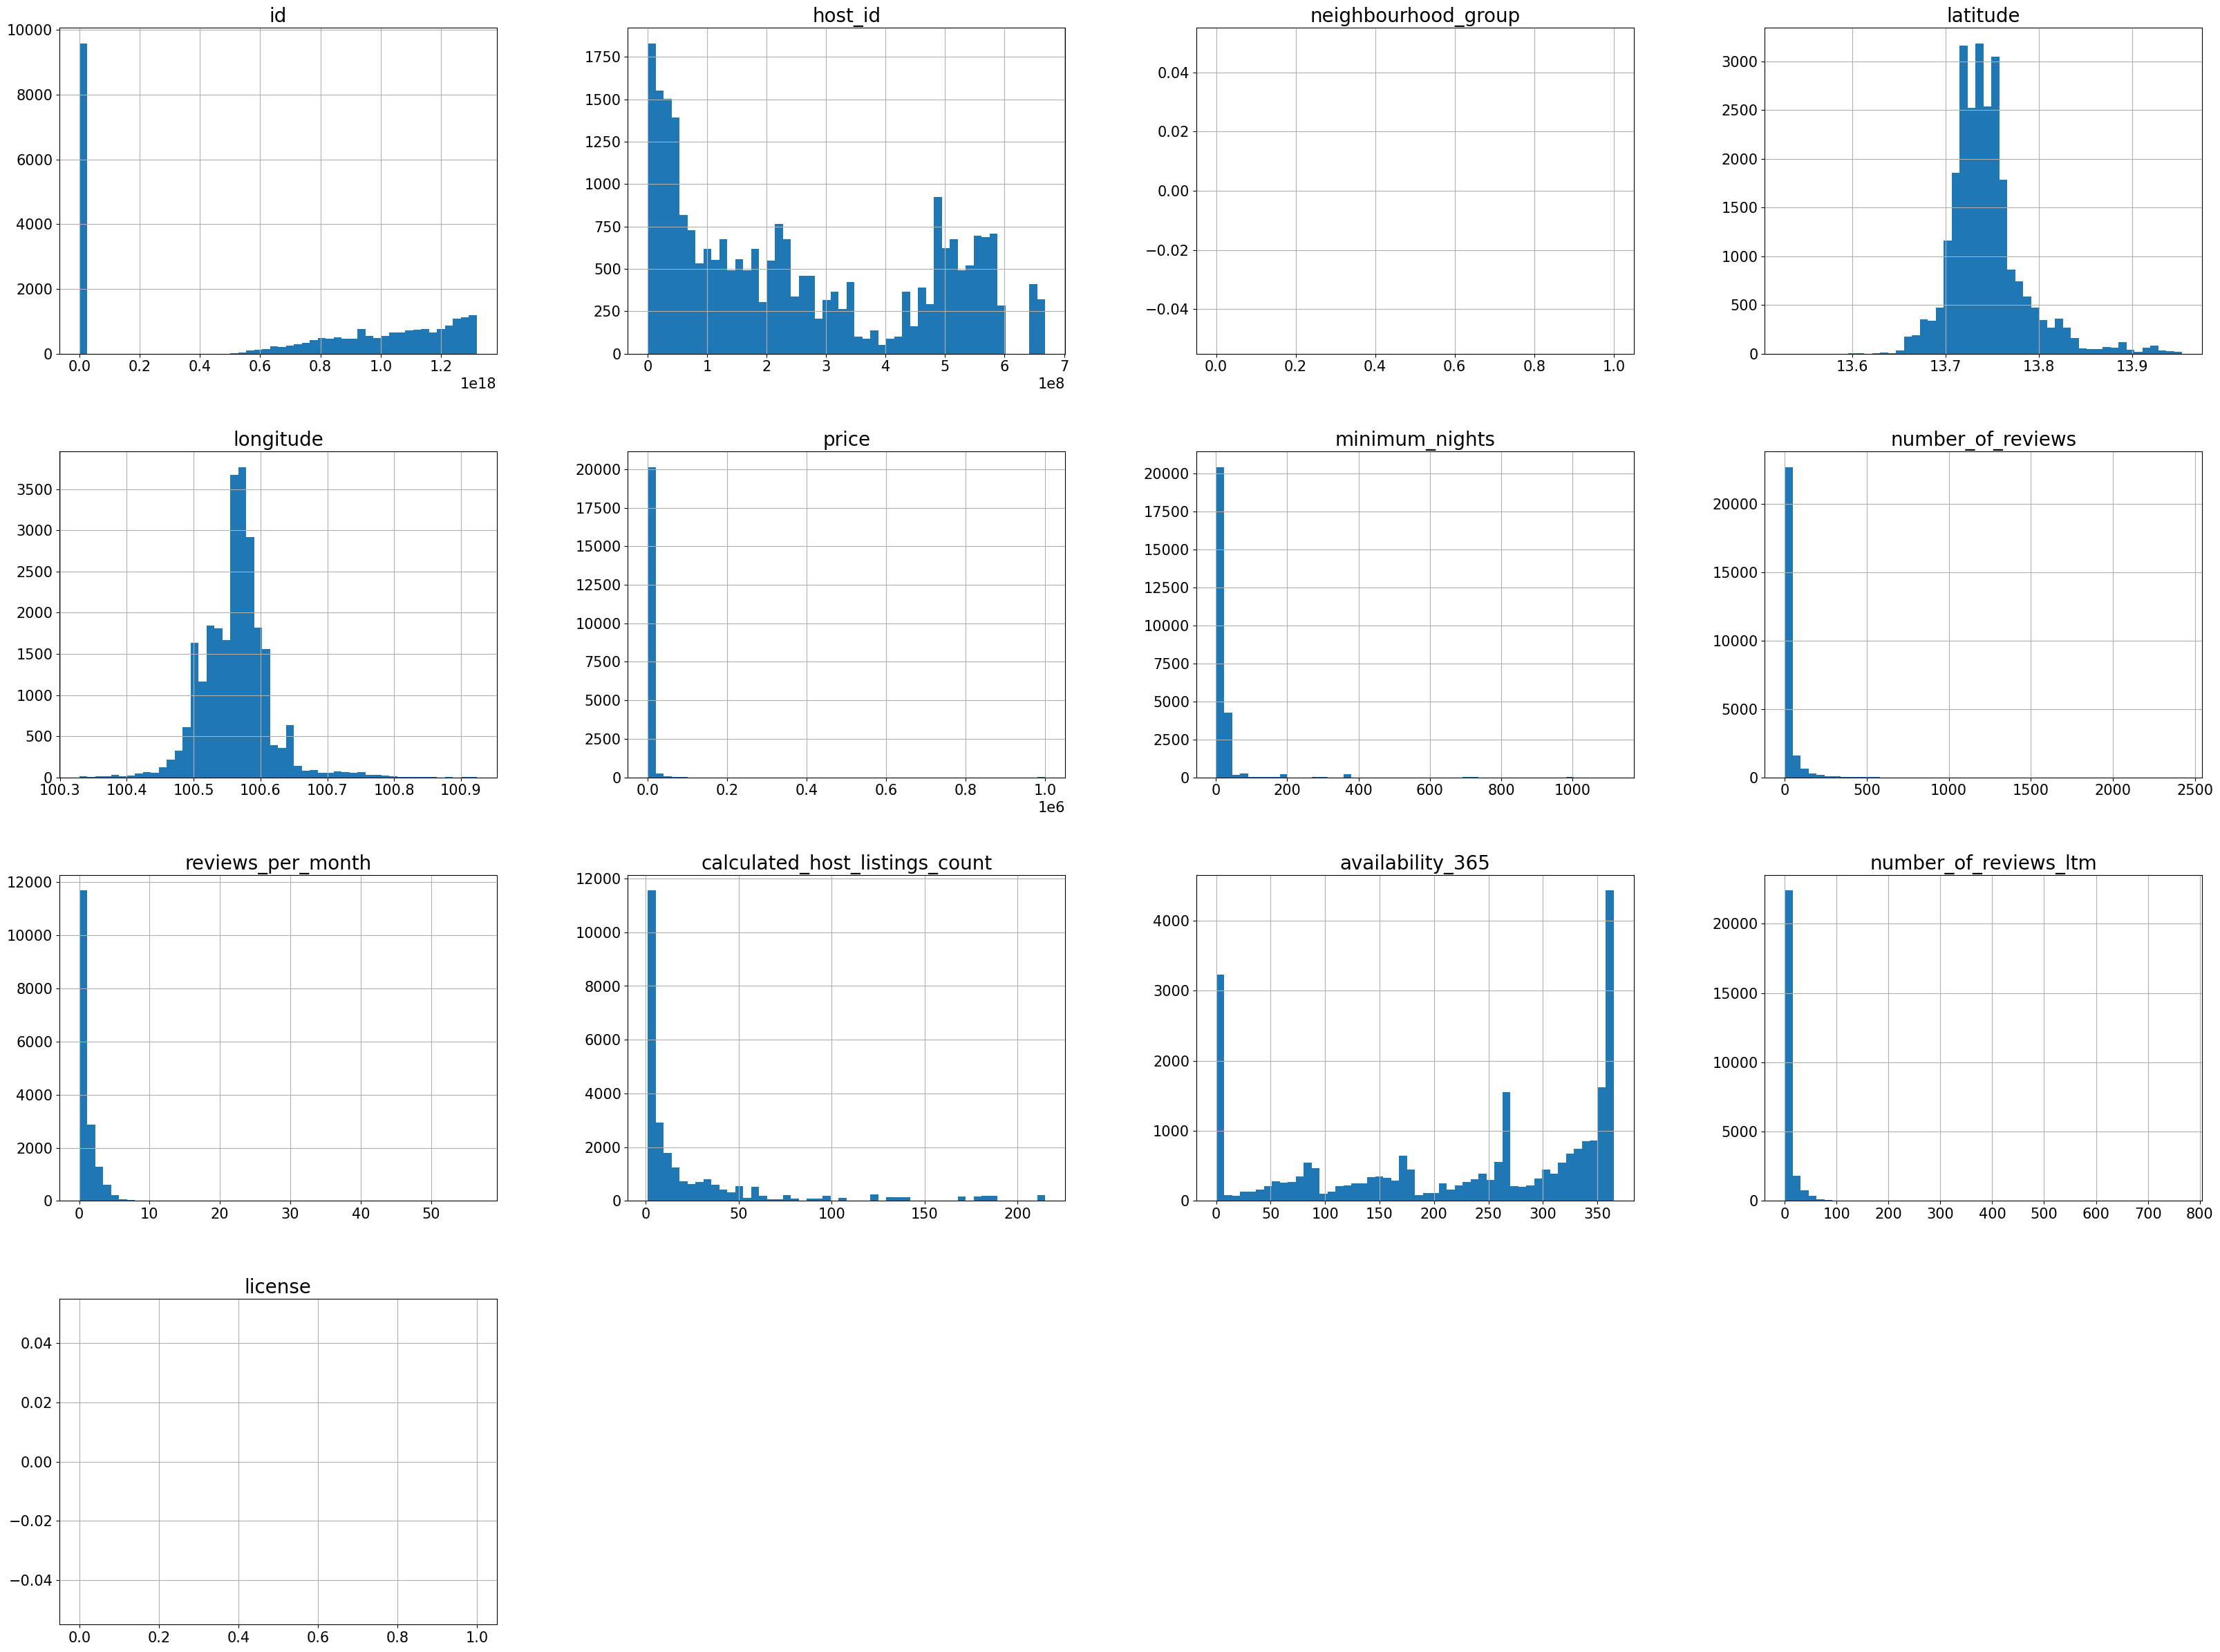

In [ ]:
#check out listings_csv
listings_csv.hist(bins=50, figsize=(40,30))
listings_csv.info()
plt.rc('font', size=20)
plt.rc('axes', labelsize=20, titlesize=20)
plt.rc('legend', fontsize=20)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

<class 'pandas.core.frame.DataFrame'>
Index: 14153 entries, 0 to 25543
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              14153 non-null  int64  
 1   name                            14153 non-null  object 
 2   host_id                         14153 non-null  int64  
 3   host_name                       14153 non-null  object 
 4   neighbourhood                   14153 non-null  object 
 5   latitude                        14153 non-null  float64
 6   longitude                       14153 non-null  float64
 7   room_type                       14153 non-null  object 
 8   price                           14153 non-null  float64
 9   minimum_nights                  14153 non-null  int64  
 10  number_of_reviews               14153 non-null  int64  
 11  last_review                     14153 non-null  object 
 12  reviews_per_month               14153

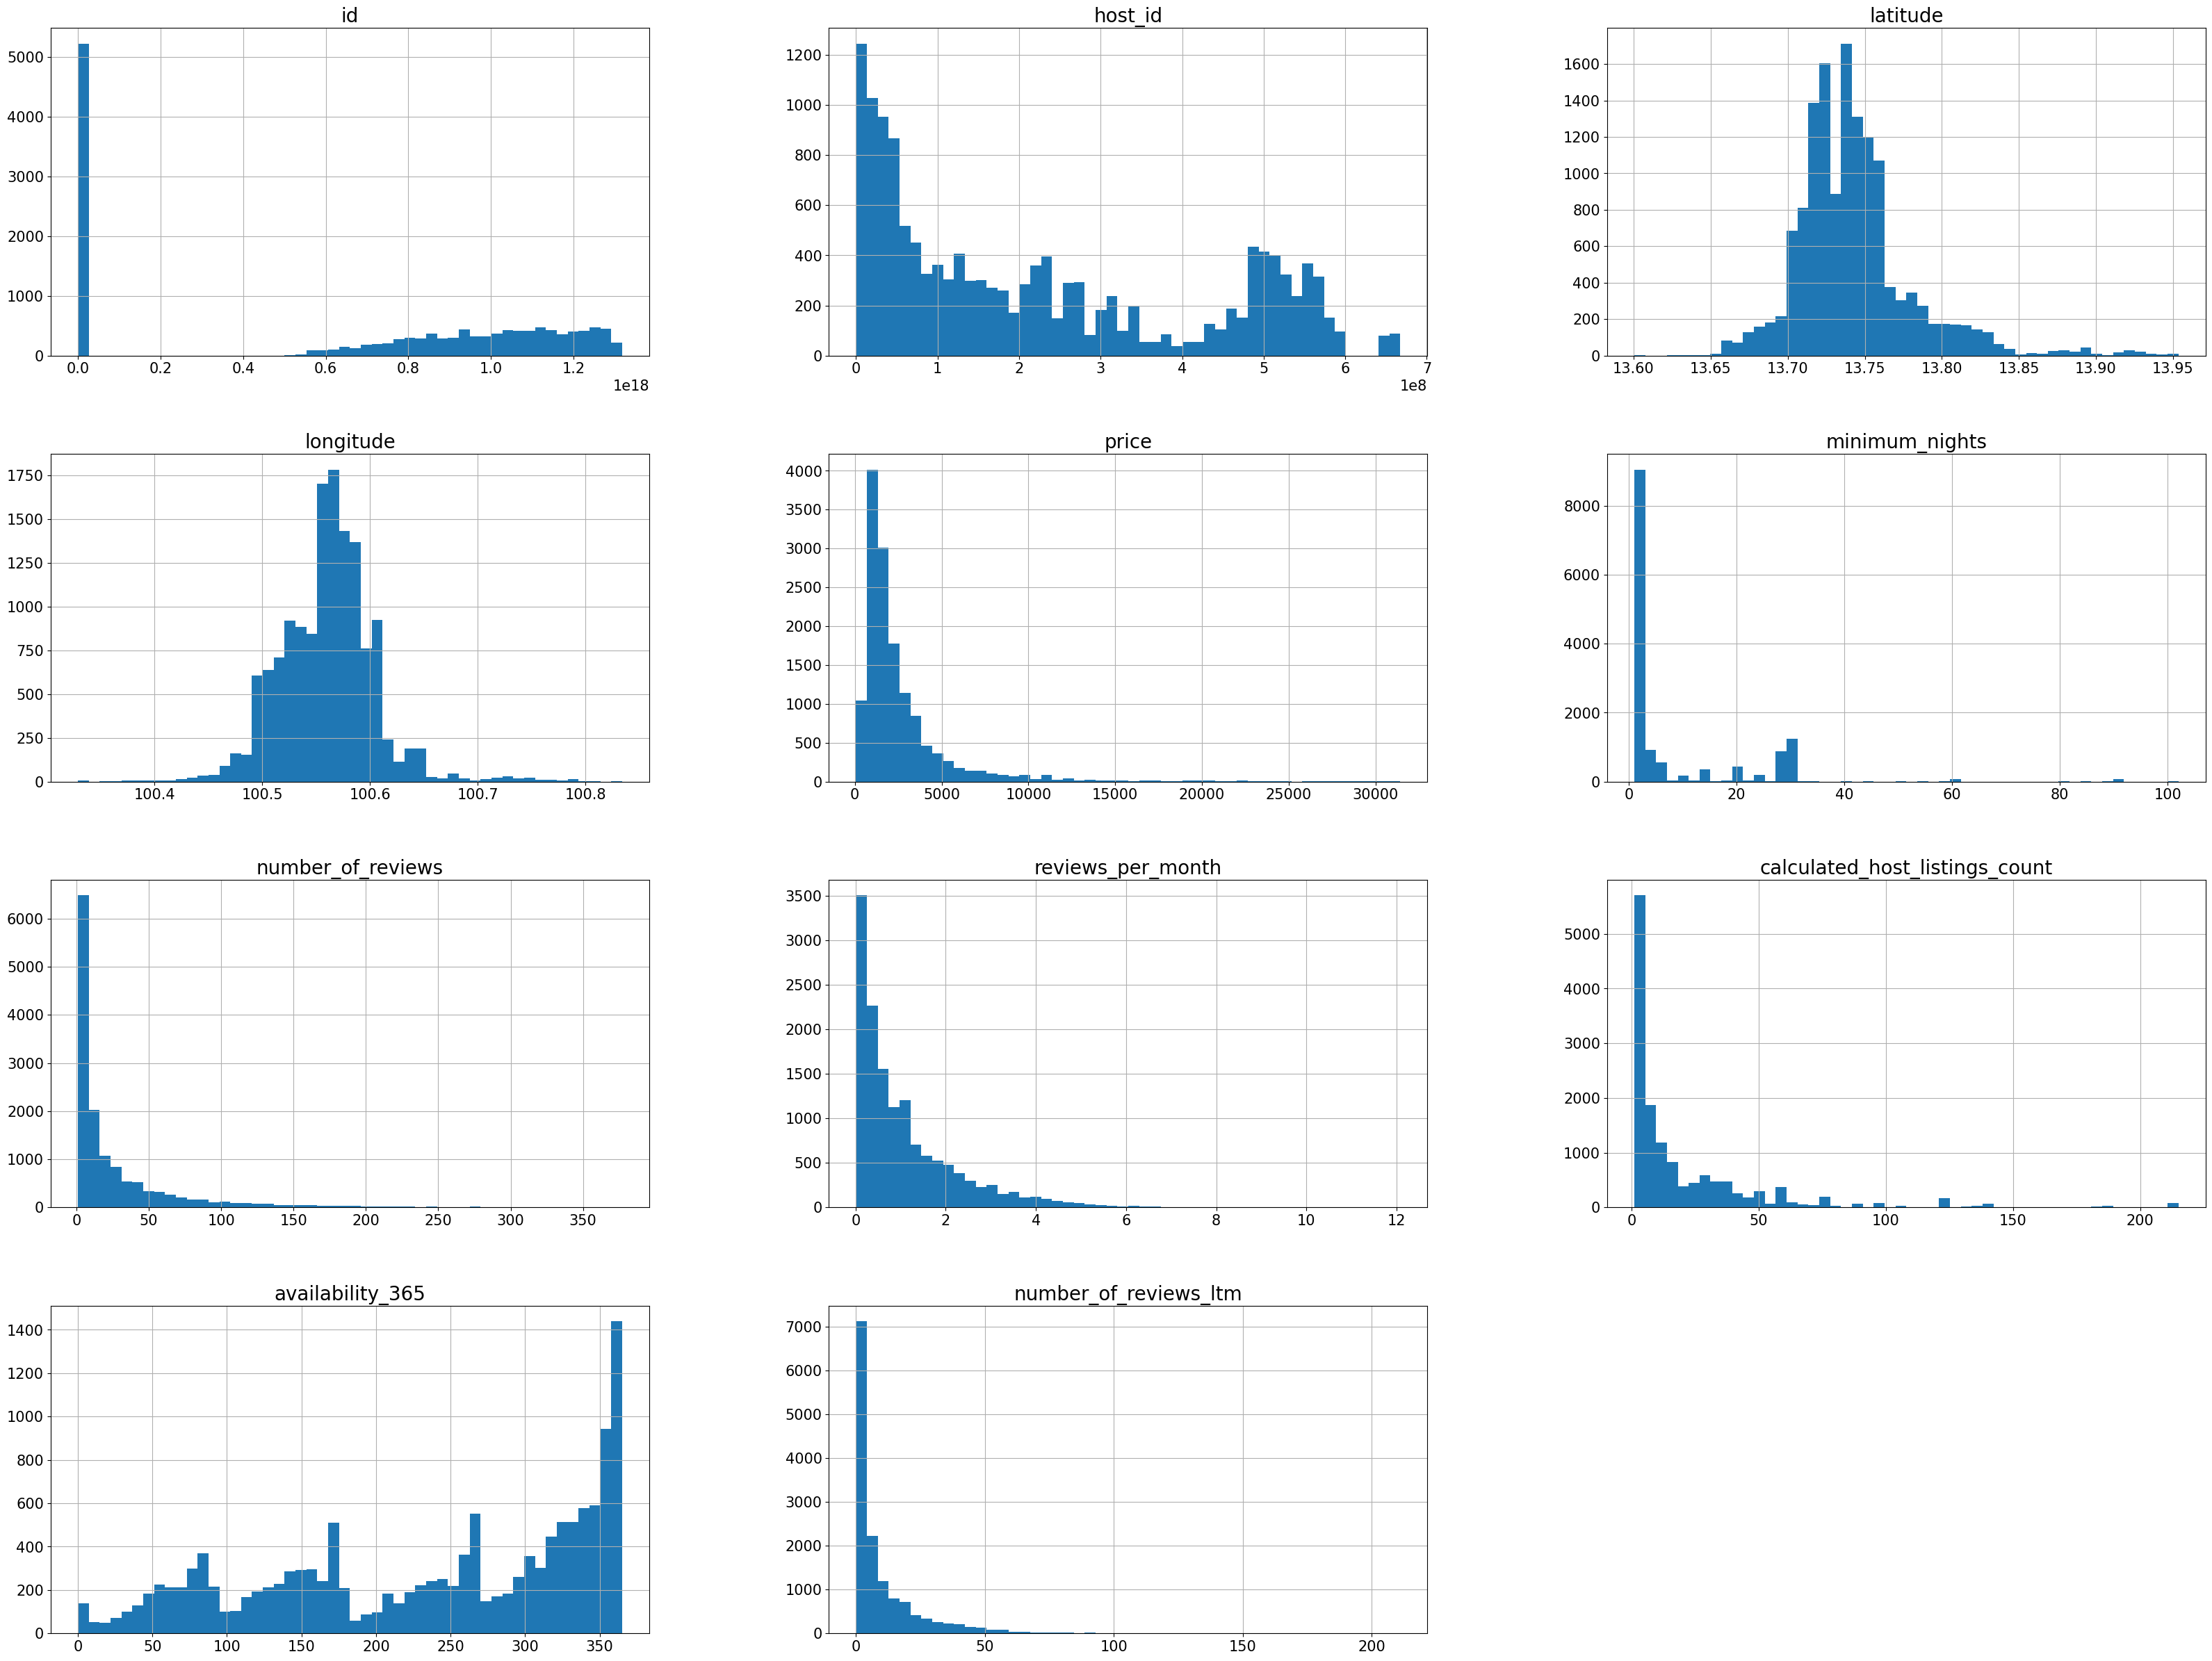

In [ ]:
def remove_outliner(raw,columns,factor=2.5):
    csv=raw.copy()
    for column in columns:

        Q1 = csv[column].quantile(0.05)
        Q3 = csv[column].quantile(0.95)
        IQR = Q3 - Q1

        lower = Q1 - factor * IQR
        upper = Q3 + factor * IQR
        csv = csv[(csv[column] >= lower) & (csv[column] <= upper)]
    return csv 
listings_csv_cleaned=remove_outliner(listings_csv,["price","number_of_reviews","reviews_per_month","calculated_host_listings_count","minimum_nights"]).dropna(axis="columns", how="all")
listings_csv_cleaned.info()
listings_csv_cleaned.hist(bins=50, figsize=(40,30))
plt.rc('font', size=20)
plt.rc('axes', labelsize=20, titlesize=20)
plt.rc('legend', fontsize=20)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()

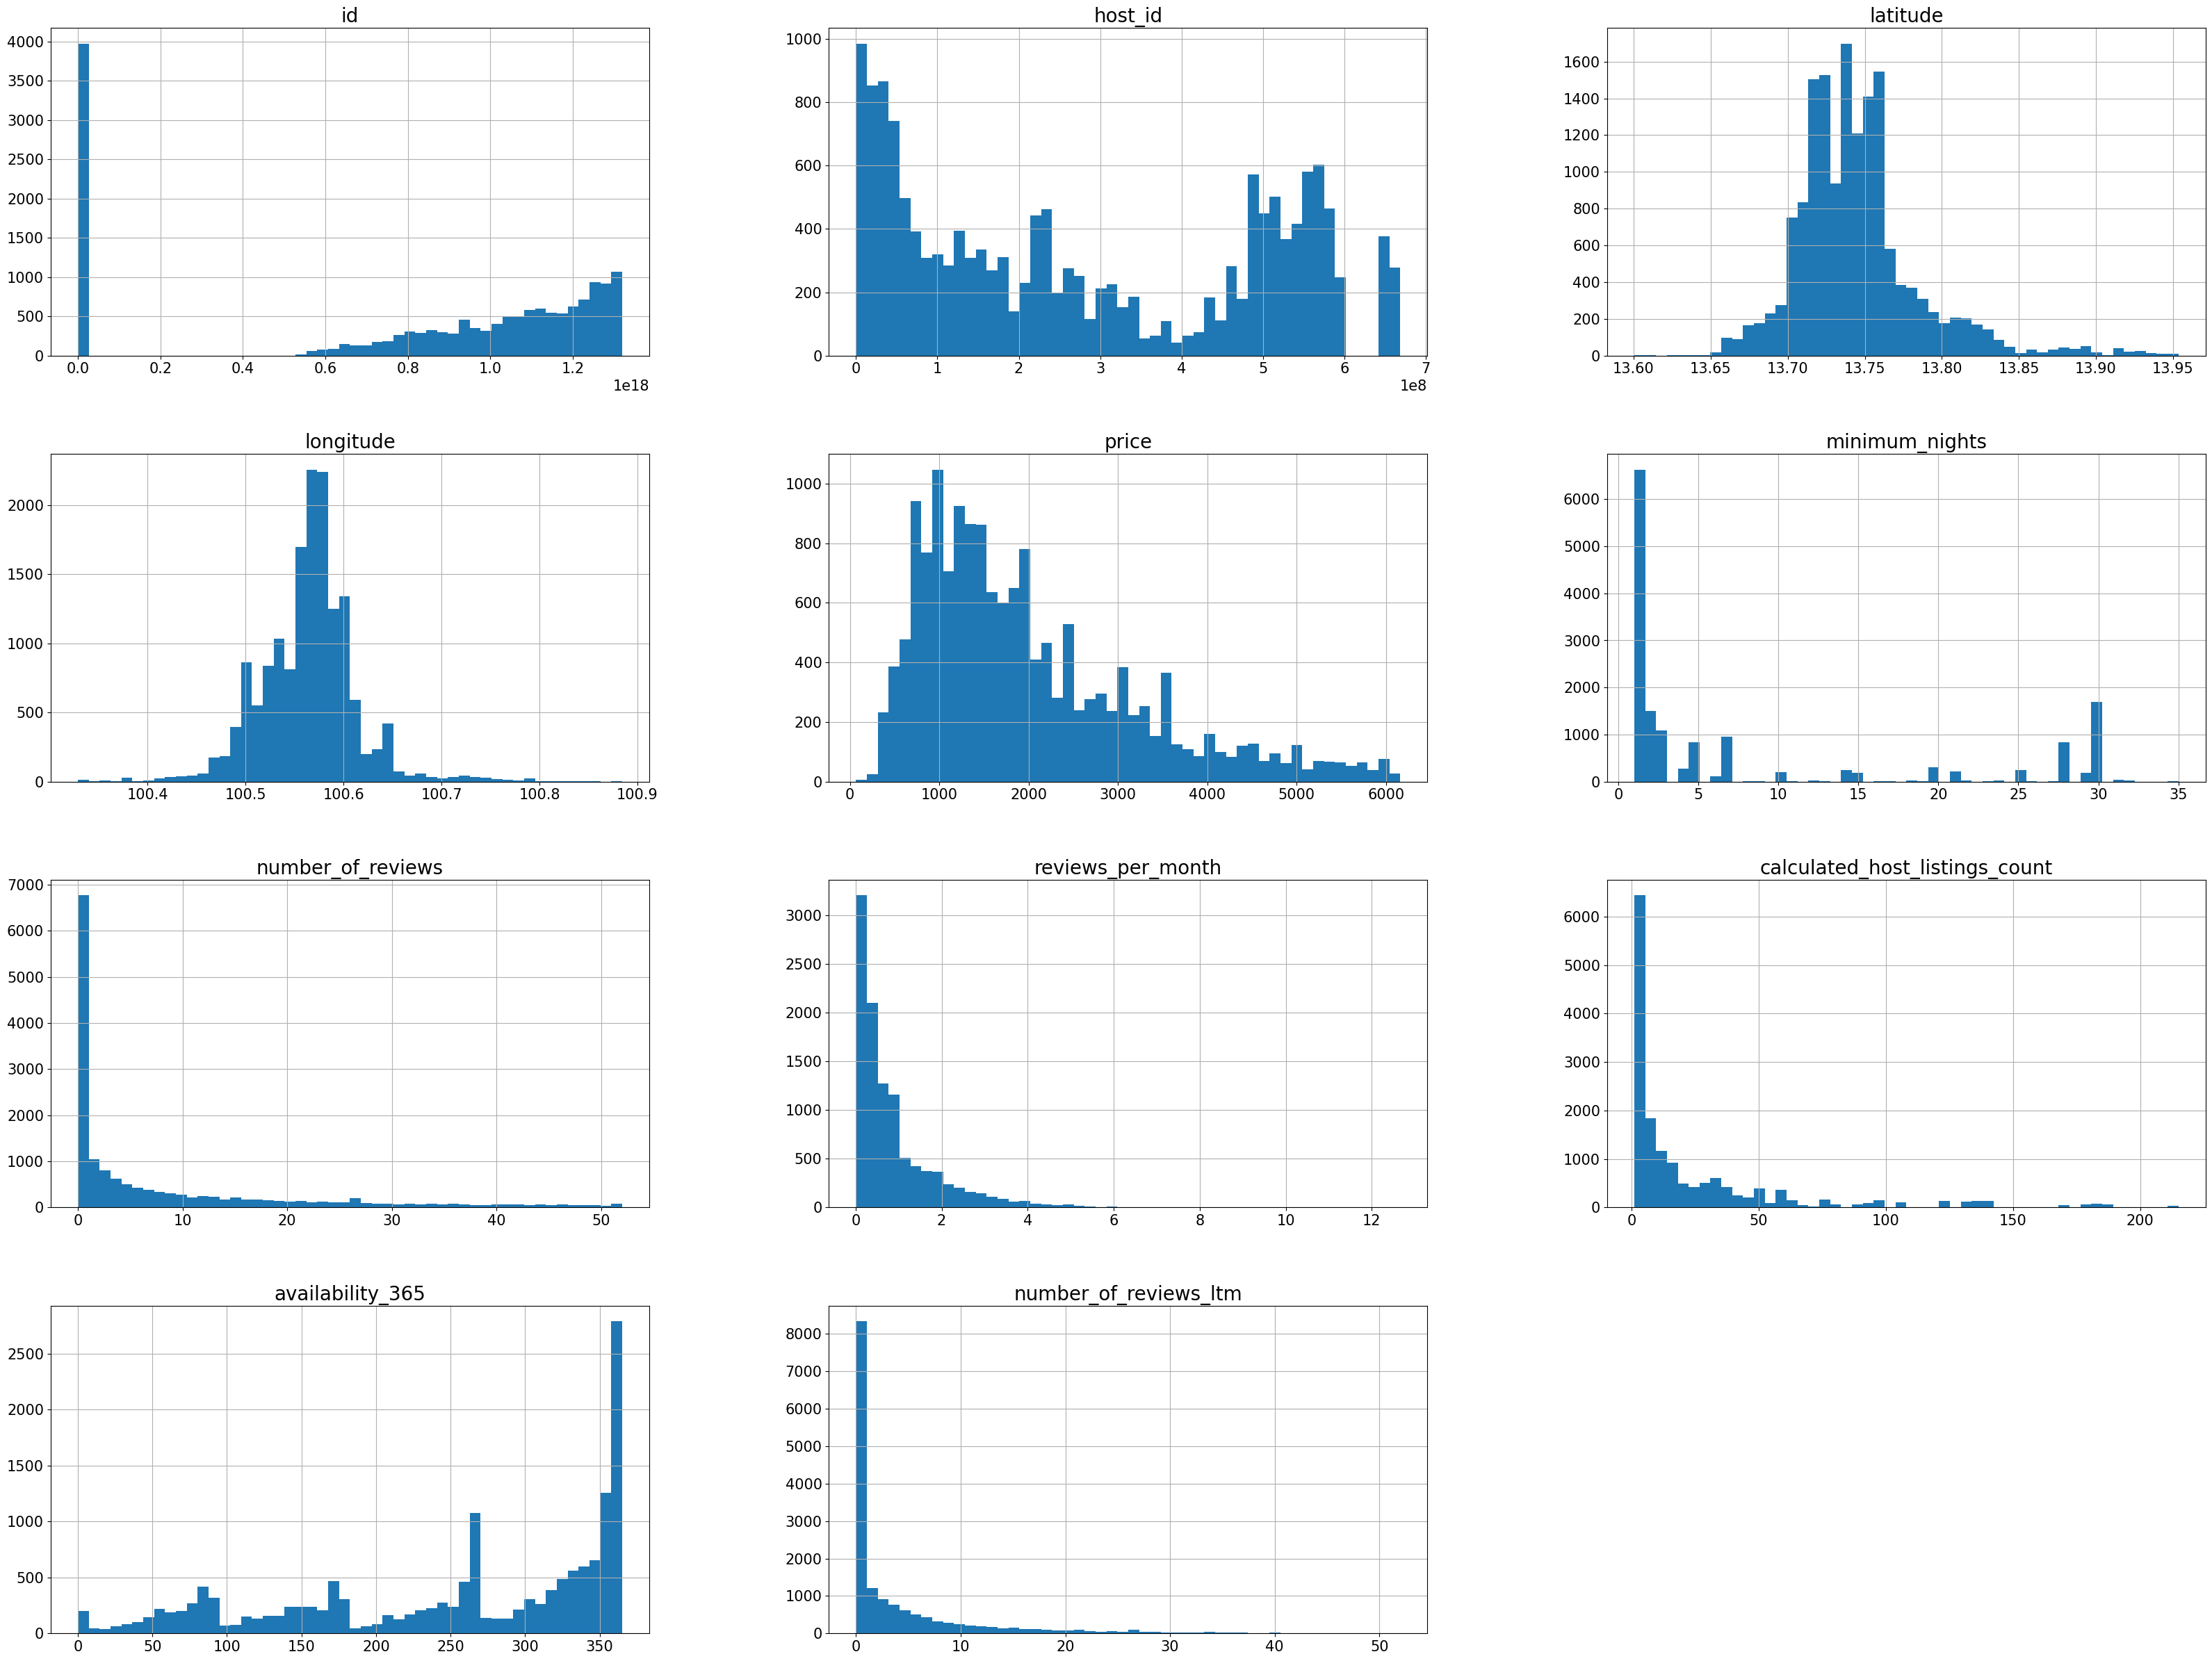

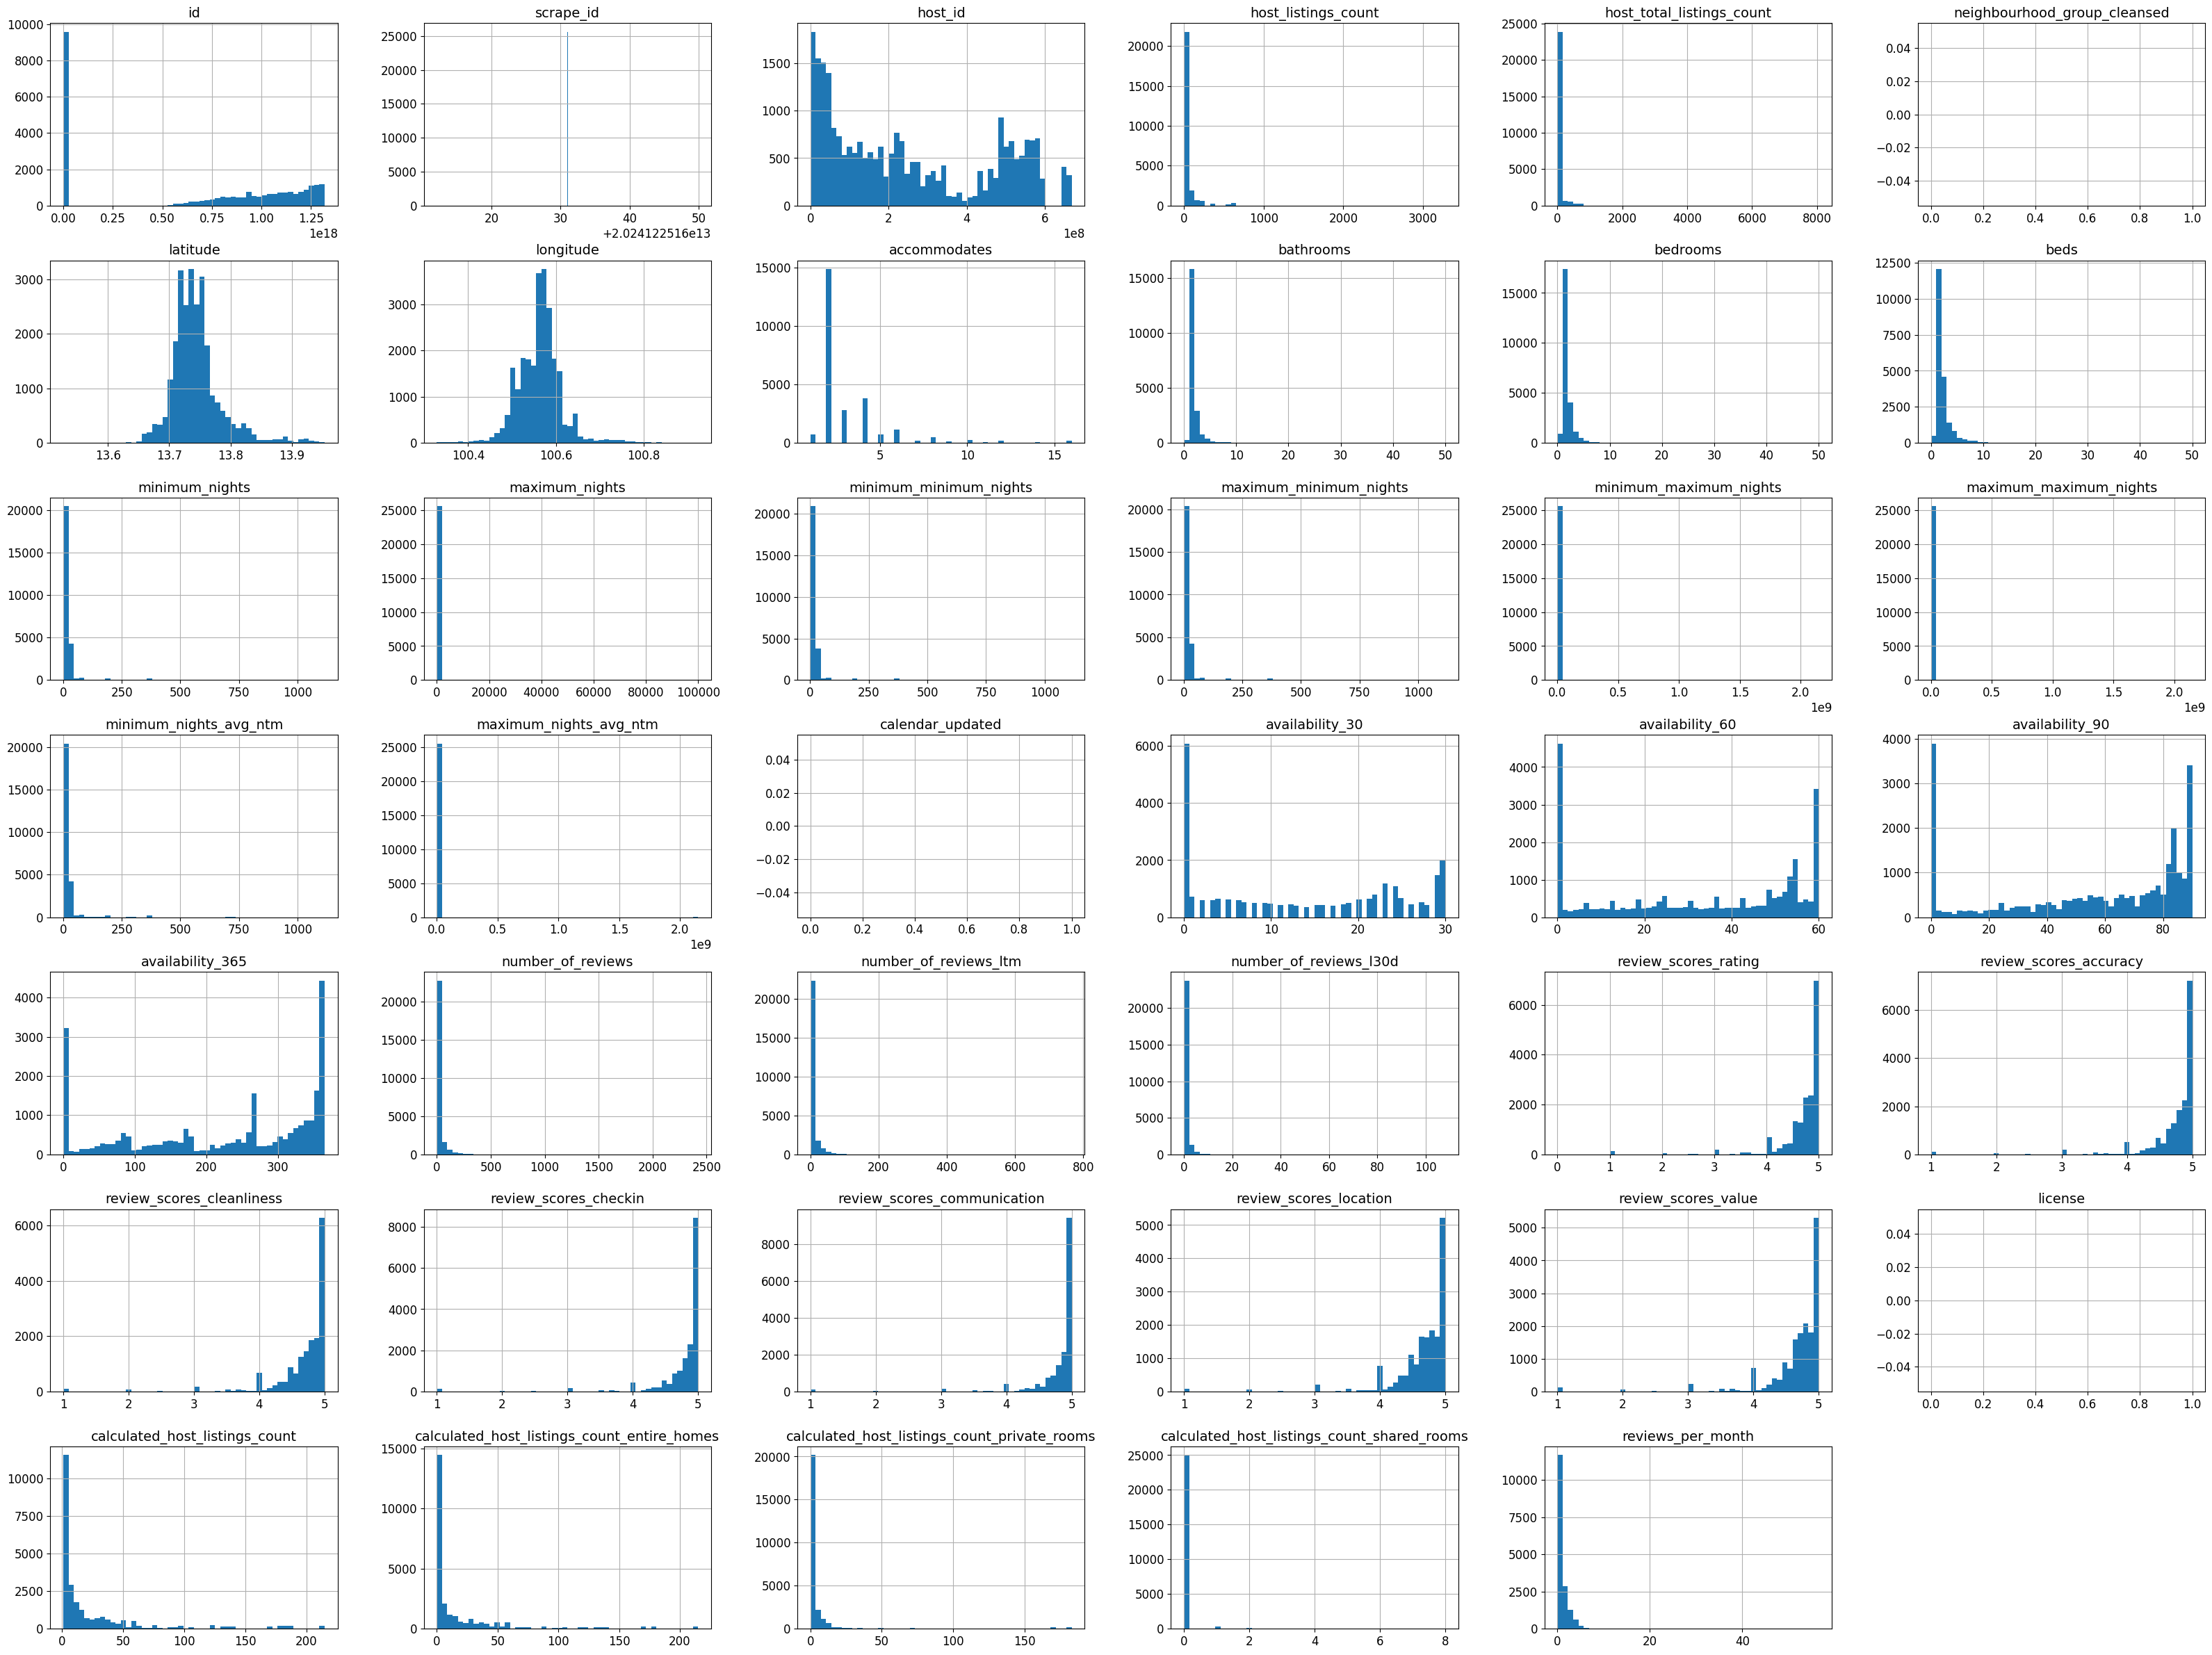

In [ ]:
pf2.hist(bins=50, figsize=(40,30))
plt.rc('font', size=20)
plt.rc('axes', labelsize=20, titlesize=20)
plt.rc('legend', fontsize=20)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.subplots_adjust(hspace=0.3, wspace=0.3)
plt.show()


In [ ]:
def clean_data(Path):
    processed_path= Path.replace("raw","processed")
    pf = pd.read_csv(Path,low_memory=False).dropna(axis="columns", how="all").dropna()
    output_dir = os.path.dirname(processed_path)
    os.makedirs(output_dir, exist_ok=True) 
    pf.to_csv(processed_path,index=False)
def clean_all_nan_data():
    for root, dirs, files in os.walk("../raw"):
        for filename in files:
            path = os.path.join(root,filename)
            if filename.endswith(".csv") or filename.endswith(".csv.gz"):
                clean_data(path)
clean_all_nan_data()
